In [1]:
#Load libraries

import numpy as np
import pandas as pd
import math
import random
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split #Data split function
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
#This notebook is second version the project. The original data was not available, so we'll convert our data to a format that resembles the original data.
#The script inside of the first for loop modified from https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py


def minimal_data(df):
    
    train = pd.DataFrame(df)
    pd.unique(train['subEventName'])
    shots=train[train['subEventName']=='Shot']
    minimal_df=pd.DataFrame(columns=['goal','x','y'])

    for i,shot in shots.iterrows():
    
        stop=0       
        if not(stop):        
            minimal_df.at[i,'x']=100-shot['positions'][0]['x']
            minimal_df.at[i,'y']=shot['positions'][0]['y']

            #Was it a goal
            minimal_df.at[i,'goal']=0
            for shottags in shot['tags']:
                    #Tags contain that its a goal
                    if shottags['id']==101:
                        minimal_df.at[i,'goal']=1
                        
            for shottags in shot['tags']:
                    if shottags['id']==403:
                        minimal_df.at[i,'head']=1
                        minimal_df.at[i,'foot']=0

                    else:
                        minimal_df.at[i,'head']=0
                        minimal_df.at[i,'foot']=1

                        
    minimal_df['x'] = minimal_df['x'].astype('int64')
    minimal_df['y'] = minimal_df['y'].astype('int64')
    minimal_df['goal'] = minimal_df['goal'].astype('int64')

    #Mirror X-coordinates if the shot is from the side X < 50
    
    counter = 0
    xnormal = minimal_df['x'].tolist()
    xmirror = []
    for i in range(len(xnormal)):
        f = 0        
        x=xnormal[counter]
        if x < 50:
            f = 100 - x
        else:
            f = x
        xmirror.append(f)
        counter = counter + 1
    
    del minimal_df['x']
    minimal_df['x'] = xmirror



    return(minimal_df[['x','y','goal','head','foot']])


# Load data

In [3]:
shots_euro_champ = minimal_data(pd.read_json('data/events_European_Championship.json'))
print('shots_euro_champ done')
shots_france = minimal_data(pd.read_json('data/events_France.json'))
print('shots_france done')
shots_germany = minimal_data(pd.read_json('data/events_Germany.json'))
print('shots_germany done')
shots_italy = minimal_data(pd.read_json('data/events_Italy.json'))
print('shots_italy done')
shots_spain = minimal_data(pd.read_json('data/events_Spain.json'))
print('shots_spain done')
shots_world_cup = minimal_data(pd.read_json('data/events_World_Cup.json'))


shots_euro_champ done
shots_france done
shots_germany done
shots_italy done
shots_spain done


In [4]:
shots_france.head()

,x,y,goal,head,foot
213,94,57,1,0.0,1.0
302,83,42,0,0.0,1.0
498,96,43,1,0.0,1.0
577,84,21,0,0.0,1.0
629,73,51,0,0.0,1.0


In [5]:
shots_germany.head()

,x,y,goal,head,foot
104,83,66,0,0.0,1.0
178,95,59,1,0.0,1.0
216,91,66,0,0.0,1.0
220,88,49,0,0.0,1.0
313,74,42,0,0.0,1.0


In [6]:
shots_italy.head()

,x,y,goal,head,foot
68,80,41,0,0.0,1.0
90,95,33,0,0.0,1.0
213,72,63,0,0.0,1.0
426,91,62,0,0.0,1.0
435,86,26,0,0.0,1.0


In [7]:
shots_spain.head()

,x,y,goal,head,foot
20,93,34,0,0.0,1.0
22,80,59,0,0.0,1.0
107,88,57,0,0.0,1.0
111,87,66,0,0.0,1.0
228,75,40,0,0.0,1.0


In [8]:
shots_world_cup.head()

,x,y,goal,head,foot
117,87,27,0,0.0,1.0
154,90,69,0,0.0,1.0
197,86,30,0,0.0,1.0
232,93,60,1,0.0,1.0
372,86,38,0,0.0,1.0


## 1. Probabilities for making a goal from a certain spot

In [9]:
#Adding all frames together, creating a simple dataset with coordinates and goals

selected = ['x', 'y', 'goal']
frame1 = shots_world_cup[selected]
frame2 = shots_euro_champ[selected]
frame3 = shots_france[selected]
frame4 = shots_spain[selected]
frame5 = shots_italy[selected]
frame6 = shots_germany[selected]
traindata = frame1.append([frame2,frame3,frame4,frame5,frame6])


### 1.1 Calculate distances from goal and degrees of visibility

This idea for calculating a xG model for soccer by using distances from goal + degrees of visibility is borrowed from this person:<br>
https://www.youtube.com/watch?v=bpjLyFyLlXs<br>

This method was explained as most useful when using Logistic Regression<br>
All code is self-made, including all the math functions.

In [10]:
#Distance from goal
#Goal midpoint coordinates:
#x = 100
#y = 50

import math

def goaldistance(xcoor,ycoor):
    return math.sqrt(((100-xcoor)**2)+((50-ycoor)**2))


In [11]:
#Degrees of visibility to goal
#Goal endpoint coordinates: (100,53) and (100,47)


def goaldegrees(xcoor,ycoor):
    if xcoor == 100:
        return 0
    else:
        m1 = (53-ycoor)/(100-xcoor) + 0.00000001
        m2 = (47-ycoor)/(100-xcoor) + 0.00000001
        yyy = (m2-m1)/(1+(m2*m1))
        ddd = abs(yyy)
        atand=math.atan(ddd)  
        degrs=math.degrees(atand)
        return degrs

#test
print(goaldegrees(86,38))


14.239707600105389


In [12]:
#Defining functions to add degrees and distances to a list

def add_degrees(pdframe):
    ylist = pdframe['y'].tolist()
    xlist = pdframe['x'].tolist()
    indx = 0
    d_list = []
    for x in xlist:
        y=ylist[indx]
        degr = goaldegrees(x,y)
        d_list.append(degr)
        indx = indx + 1
    pdframe['goaldegrees']=d_list
    
def add_distances(pdframe):
    ylist = pdframe['y'].tolist()
    xlist = pdframe['x'].tolist()
    indx = 0
    dlist = []
    for x in xlist:
        y=ylist[indx]
        dist = goaldistance(x,y)
        dlist.append(dist)
        indx = indx + 1
    pdframe['distances']=dlist


In [13]:
add_degrees(traindata)
add_distances(traindata)

In [14]:
traindata.head()

,x,y,goal,goaldegrees,distances
117,87,27,0,6.458816,26.419690
154,90,69,0,7.561428,21.470911
197,86,30,0,8.143767,24.413111
232,93,60,1,16.699244,12.206556
372,86,38,0,14.239708,18.439089


In [15]:
#Removing xy coordinates

traindata1 = traindata[['goal','goaldegrees','distances']]
traindata1.head()


,goal,goaldegrees,distances
117,0,6.458816,26.419690
154,0,7.561428,21.470911
197,0,8.143767,24.413111
232,1,16.699244,12.206556
372,0,14.239708,18.439089


In [16]:
traindata1['goal'].value_counts()


0    31049
1     3578
Name: goal, dtype: int64

In [17]:
#https://elitedatascience.com/imbalanced-classes

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = traindata1[traindata1.goal==0]
df_minority = traindata1[traindata1.goal==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3578,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
goals_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
goals_downsampled.goal.value_counts()


0    3578
1    3578
Name: goal, dtype: int64

### 1.2. Train test split

In [18]:
#set x,y, train test split + randomize

y = goals_downsampled['goal'].values
X = goals_downsampled.loc[:, goals_downsampled.columns != 'goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


### 1.3. Logistic Regression

In [19]:
#L2

lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train) #define Logistic Regression classifier


In [20]:
y_pred_lr = lr.predict(X_test)
y_predProba_lr = lr.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr)*100).round(2))

Accuracy is:  67.91


In [21]:
confusion_matrix(y_test, y_pred_lr)

array([[696, 364],
       [325, 762]])

In [22]:
#testing the predictive capability
rivi = X_test.iloc[[2]]

In [23]:
rivi.head()

,goaldegrees,distances
275404,15.499275,22.022716


In [24]:
testi = lr.predict_proba(rivi)
print(testi)

[[0.65326826 0.34673174]]


In [25]:
#Generating all coordinates for 100x100 matrix

p_df=pd.DataFrame(columns=['x','y'])

import itertools
x_line = range(0,100)
y_line = range(0,100)

xvalues = []
yvalues = []

for item in list(itertools.product(x_line,y_line)):
    xvalues.append(item[0])
    yvalues.append(item[1])

p_df['x'] = xvalues
p_df['y'] = yvalues

In [26]:
add_degrees(p_df)
add_distances(p_df)


In [27]:
#taking the xy coordinates away
p_df1=p_df[['goaldegrees','distances']]
p_df1.head()

,goaldegrees,distances
0,2.750065,111.803399
1,2.772001,111.359777
2,2.793836,110.923397
3,2.815557,110.494344
4,2.837149,110.072703


In [28]:
#Generating predictions for the selected XY coordinates using LR

pred_list = []
counter = -1

for x in range(len(p_df1)):
    counter = counter + 1
    p = lr.predict_proba(p_df1.iloc[[counter]])
    r = p[0][1]
    f = round(r, 5)
    pred_list.append(f)


#Test
print(pred_list[:5]) 

[1e-05, 1e-05, 2e-05, 2e-05, 2e-05]


In [29]:
#Adding prediction to the list
p_df1['prediction'] = pred_list
p_df1.head()

<ipython-input-29-8ab2a90e8ec7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df1['prediction'] = pred_list


,goaldegrees,distances,prediction
0,2.750065,111.803399,0.00001
1,2.772001,111.359777,0.00001
2,2.793836,110.923397,0.00002
3,2.815557,110.494344,0.00002
4,2.837149,110.072703,0.00002


In [30]:
#Double check to see if uneven list lenght was somehow introduced
p_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   goaldegrees  10000 non-null  float64
 1   distances    10000 non-null  float64
 2   prediction   10000 non-null  float64
dtypes: float64(3)
memory usage: 234.5 KB


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
#Creating a dataframe for using with heatmap with the original xy coordinates
hm1 = p_df[['x','y',]] 
hm1['prediction'] = p_df1['prediction']
hm1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           10000 non-null  int64  
 1   y           10000 non-null  int64  
 2   prediction  10000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 234.5 KB


<ipython-input-32-beb2f798e226>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm1['prediction'] = p_df1['prediction']


In [33]:
#Creating a pivot table with XY coordinates

hm_gp = pd.pivot_table(data=hm1,
                      index='y',
                      values='prediction',
                      columns='x')
hm_gp.fillna(0, inplace=True)

In [34]:
hm_gp.head()

x,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
y,,,,,,,,,,,,,,,,,,,,,
0,0.00001,0.00002,0.00002,0.00002,0.00002,0.00002,0.00003,0.00003,0.00003,0.00003,...,0.01619,0.01652,0.01683,0.01710,0.01734,0.01755,0.01771,0.01784,0.01793,0.01797
1,0.00001,0.00002,0.00002,0.00002,0.00002,0.00002,0.00003,0.00003,0.00003,0.00004,...,0.01812,0.01850,0.01885,0.01916,0.01944,0.01967,0.01986,0.02000,0.02010,0.02015
2,0.00002,0.00002,0.00002,0.00002,0.00002,0.00003,0.00003,0.00003,0.00004,0.00004,...,0.02027,0.02071,0.02111,0.02147,0.02178,0.02204,0.02226,0.02242,0.02253,0.02259
3,0.00002,0.00002,0.00002,0.00002,0.00002,0.00003,0.00003,0.00003,0.00004,0.00004,...,0.02268,0.02318,0.02363,0.02404,0.02439,0.02469,0.02494,0.02512,0.02525,0.02532
4,0.00002,0.00002,0.00002,0.00002,0.00003,0.00003,0.00003,0.00004,0.00004,0.00004,...,0.02536,0.02593,0.02644,0.02691,0.02731,0.02765,0.02793,0.02814,0.02829,0.02836


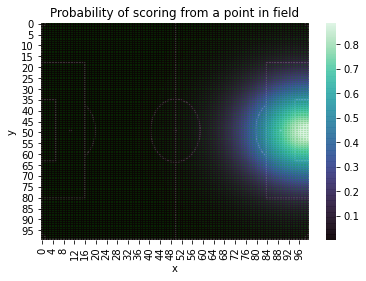

In [35]:
##Guide of creating a heatmap using pivot table
## https://stackabuse.com/ultimate-guide-to-heatmaps-in-seaborn-with-python/

##Using image background:
## https://stackoverflow.com/questions/50091591/plotting-seaborn-heatmap-on-top-of-a-background-picture


import matplotlib.image as mpimg 
map_img = mpimg.imread('footballfield.png') 

## Image source: Wikipedia, no copyright issues :p

heatmap = sns.heatmap(hm_gp,
                      cmap='mako',
                      alpha = 0.8,
                      zorder = 2
                     )


heatmap.imshow(map_img,
          aspect = heatmap.get_aspect(),
          extent = heatmap.get_xlim() + heatmap.get_ylim(),
          zorder = 1) #put the map under the heatmap

plt.title('Probability of scoring from a point in field')

plt.savefig('soccerfield.png', dpi=300, transparent=True)
plt.show()

## 2. Building xG model with all attributes from data

Unlike in previous model that merely tried to understand the relationship between a point in field and the likelihood of scoring, in this model we will use all of the useful columns in the data, including the information if the shot was header or shot with feet. This model will be used for comparing different teams by how many expected goals they make on average.

### 2.1. Data

In [36]:
#Adding all frames together, creating a simple dataset with coordinates and goals

selected = ['x', 'y', 'foot','head','goal']
frame1 = shots_world_cup[selected]
frame2 = shots_euro_champ[selected]
frame3 = shots_france[selected]
frame4 = shots_spain[selected]
frame5 = shots_italy[selected]
frame6 = shots_germany[selected]
traindata2 = frame1.append([frame2,frame3,frame4,frame5,frame6])

#adding feet together since some are just left-legged
traindata=traindata2[['x', 'y', 'foot','head','goal']]



In [37]:
add_degrees(traindata)
add_distances(traindata)

In [38]:
traindata1 = traindata[['goaldegrees','distances','foot','head','goal']]
traindata1.head()

,goaldegrees,distances,foot,head,goal
117,6.458816,26.419690,1.0,0.0,0
154,7.561428,21.470911,1.0,0.0,0
197,8.143767,24.413111,1.0,0.0,0
232,16.699244,12.206556,1.0,0.0,1
372,14.239708,18.439089,1.0,0.0,0


In [39]:
traindata1['goal'].value_counts()

0    31049
1     3578
Name: goal, dtype: int64

In [40]:
#https://elitedatascience.com/imbalanced-classes

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = traindata1[traindata1.goal==0]
df_minority = traindata1[traindata1.goal==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3578,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
goals_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
goals_downsampled.goal.value_counts()

0    3578
1    3578
Name: goal, dtype: int64

### 2.2. Train test split

In [41]:
#set x,y, train test split + randomize

y = goals_downsampled['goal'].values
X = goals_downsampled.loc[:, goals_downsampled.columns != 'goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)



### 2.3. Logistic Regression

In [42]:
#L2
lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train) #define Logistic Regression classifier


In [43]:
y_pred_lr = lr.predict(X_test)
y_predProba_lr = lr.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr)*100).round(2))

Accuracy is:  67.91


Interesting.<br>
The accuracy has not considerably improved even when more data was introduced.

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[696 364]
 [325 762]]
Normalized confusion matrix
[[0.66 0.34]
 [0.3  0.7 ]]


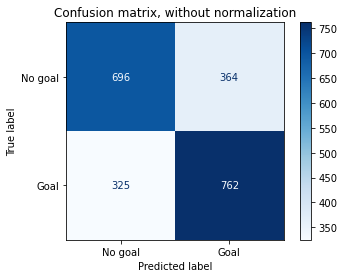

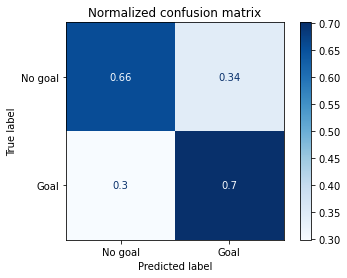

In [44]:
### Confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

class_names = ['No goal', 'Goal']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.savefig('cfmatrix.png')
plt.show()

# 

### Testing if L1 makes a difference

In [45]:
#Testing LR1
lr1 = LogisticRegression(solver='liblinear', penalty="l1", max_iter=10000).fit(X_train, y_train)

In [46]:
y_pred_lr1 = lr1.predict(X_test)
y_predProba_lr1 = lr1.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr1)*100).round(2))

Accuracy is:  67.96


In [47]:
confusion_matrix(y_test, y_pred_lr)

array([[696, 364],
       [325, 762]])

## 3. Comparing different teams

In [48]:
#Frame with different teams

shots_france['Country']='France'
shots_spain['Country']='Spain'
shots_italy['Country']='Italy'
shots_germany['Country']='Germany'
countries_frame = shots_france.append([shots_spain,shots_italy,shots_germany])

#Add degrees and distances
add_degrees(countries_frame)
add_distances(countries_frame)

#Make another df understandable for LR
teams= countries_frame[['goaldegrees','distances','foot','head']]

In [49]:
teams.head()

,goaldegrees,distances,foot,head
213,25.346176,9.219544,1.0,0.0
302,16.515702,18.788294,1.0,0.0
498,23.198590,8.062258,1.0,0.0
577,5.042451,33.120990,1.0,0.0
629,12.663364,27.018512,1.0,0.0


In [50]:
countries_frame.head()

,x,y,goal,head,foot,Country,goaldegrees,distances
213,94,57,1,0.0,1.0,France,25.346176,9.219544
302,83,42,0,0.0,1.0,France,16.515702,18.788294
498,96,43,1,0.0,1.0,France,23.198590,8.062258
577,84,21,0,0.0,1.0,France,5.042451,33.120990
629,73,51,0,0.0,1.0,France,12.663364,27.018512


In [51]:
#Generating predictions for all of the teams using LR

lenght = len(teams)

probabilities = []
ex_goals = []
counter = -1

for x in range(0,lenght):
    counter = counter + 1
    p = lr.predict_proba(teams.iloc[[counter]])
    r = p[0][1]
    f = round(r, 5)
    exgoal = lr.predict(teams.iloc[[counter]])
    probabilities.append(f)
    ex_goals.append(exgoal[0])
    

#Test
print(probabilities[:5])
print(ex_goals[:5])


[0.71618, 0.438, 0.7401, 0.11946, 0.22528]
[1, 0, 1, 0, 0]


In [52]:
comparison_frame = countries_frame[['Country', 'goal']]
comparison_frame['Goal_prediction'] = ex_goals
comparison_frame['P(Scoring)'] = probabilities


<ipython-input-52-1f77f6383925>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_frame['Goal_prediction'] = ex_goals
<ipython-input-52-1f77f6383925>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_frame['P(Scoring)'] = probabilities


In [53]:
comparison_frame.head()

,Country,goal,Goal_prediction,P(Scoring)
213,France,1,1,0.71618
302,France,0,0,0.43800
498,France,1,1,0.74010
577,France,0,0,0.11946
629,France,0,0,0.22528


In [54]:
def c_avg(co,attr):
    selected = comparison_frame.loc[comparison_frame['Country'] == co]
    return selected[attr].mean()


In [55]:
c_dict = {'Country': ['France','Spain','Germany','Italy'],
                 'Avg_goals': [c_avg('France','goal'), c_avg('Spain','goal'),c_avg('Germany','goal'),c_avg('Italy','goal')],
                 'Goal_pred': [c_avg('France','Goal_prediction'), c_avg('Spain','Goal_prediction'),c_avg('Germany','Goal_prediction'),c_avg('Italy','Goal_prediction')],
                 'Exp_goals': [c_avg('France','P(Scoring)'), c_avg('Spain','P(Scoring)'),c_avg('Germany','P(Scoring)'),c_avg('Italy','P(Scoring)')],

                }
countryvalues = pd.DataFrame (c_dict, columns = ['Country','Avg_goals','Goal_pred','Exp_goals'])
c = (countryvalues.select_dtypes(exclude=['object'])).multiply(100)
c['Country'] = countryvalues['Country']
countries_percentage = c[['Country','Avg_goals','Goal_pred','Exp_goals']]

countries_percentage.head()


,Country,Avg_goals,Goal_pred,Exp_goals
0,France,10.483968,36.819983,41.185126
1,Spain,11.079083,39.127710,42.628054
2,Germany,10.829226,39.156277,42.989772
3,Italy,9.686577,34.908017,40.742073


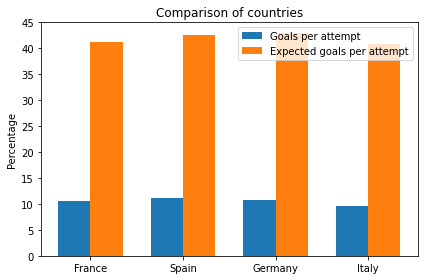

In [57]:
##https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html


labels = countries_percentage['Country'].tolist()
avg = countries_percentage['Avg_goals'].tolist()
exp = countries_percentage['Exp_goals'].tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, avg, width, label='Goals per attempt')
rects2 = ax.bar(x + width/2, exp, width, label='Expected goals per attempt')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Comparison of countries')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set(ylim=(0, 45))
ax.legend()


fig.tight_layout()

plt.savefig('countries.png', dpi=300, transparent=True)
plt.show()